# Visual Exploration of Earthquake Data

Matheus Schmitz  
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a>  
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>  

**Data Source**  
USGS worldwide earthquake report: https://earthquake.usgs.gov/earthquakes/feed/

**Goals**  
R has lots of very powerful and interesting visualization tools, I want to learn them and have fun all the while! I figured earthquakes are a pretty exciting thing, and I'm hopy they'll make for some nice plots, so let's go!

**Reminder**
For Jupyter to be able to handle all plots, this notebook must be ran with:  
``jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10``

## Setup R Environment

In [1]:
# R on Jupyter has way to many warnings that clutter everything
options(warn=-1)

In [2]:
# Define working directory
setwd("C:/Portfolio/Earthquake_Maps")
getwd()

[1] "C:/Portfolio/Earthquake_Maps"

In [4]:
# Import packages
library(maps)
library(ggplot2)
library(ggmap)
library(ggsn)
library(plyr)
library(dplyr)
library(lubridate)
library(sf)
library(spData)
library(tmap)
library(leaflet)
library(leafpop)
library(animation)
library(gganimate)
library(ggthemes)
library(gifski)
library(av)
library(geojsonio)
library(htmlwidgets)
library(magick)
library(rgdal)
library(mapview)
library(mapproj)
library(choroplethr)
library(geojsonio)
library(broom)
library(rjson)
library(plotly)
library(countrycode)

In [5]:
# Set a smaller plot size
options(repr.plot.width=16, repr.plot.height=9)

# Align all titles to the middle of the plot
theme_update(plot.title = element_text(hjust = 0.5))

# Mapview's FGB files load super fast, but can't be saved :(
mapviewOptions(fgb = FALSE)

## Loading Data

United States Geological Services (USGS) updates their earthquake dataset daily, and provides an easily accesible file containing all earthquakes worldwide within the last week, so it is possible to keep the script always updated by fetchign the file directly from the source prior to loading it!

**Dataset dictionary:** https://earthquake.usgs.gov/data/comcat/index.php#event-terms

In [6]:
# Download the earthquake data from USGS
USGS_url <- "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
download.file(url=USGS_url, destfile="all_month.csv")

In [7]:
# Read the csv
earthquakes <- read.csv("all_month.csv", header=TRUE, sep=',', stringsAsFactors = FALSE)
head(earthquakes, 2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,⋯,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,2021-05-22T02:48:02.790Z,35.90000,-117.7398,7.62,0.61,ml,9,115.0000,0.0801400,0.1000000,⋯,2021-05-22T02:51:35.347Z,"16km ESE of Little Lake, CA",earthquake,0.37000,0.83,0.358,4,automatic,ci,ci
2,2021-05-22T02:45:51.447Z,35.07395,-95.3339,5.00,2.08,ml,12,231.1307,0.1692428,0.7276103,⋯,2021-05-22T02:49:42.004Z,"6 km SSE of Quinton, Oklahoma",earthquake,6.77838,NA,NA,10,automatic,ok,ok


In [8]:
# Check for NAs
colSums(is.na(earthquakes))

time        latitude       longitude           depth             mag 
              0               0               0               0               0 
        magType             nst             gap            dmin             rms 
              0            3135            2098            3385               0 
            net              id         updated           place            type 
              0               0               0               0               0 
horizontalError      depthError        magError          magNst          status 
           2988               1            2630            2149               0 
 locationSource       magSource 
              0               0

In [9]:
# looks like the "time" column needs its data type fixed. Check if any other column also needs that.
str(earthquakes)

'data.frame':	10387 obs. of  22 variables:
 $ time           : chr  "2021-05-22T02:48:02.790Z" "2021-05-22T02:45:51.447Z" "2021-05-22T02:39:18.830Z" "2021-05-22T02:29:37.042Z" ...
 $ latitude       : num  35.9 35.1 38.8 34.9 38.8 ...
 $ longitude      : num  -117.7 -95.3 -122.8 97.4 -122.8 ...
 $ depth          : num  7.62 5 0.91 10 1.76 ...
 $ mag            : num  0.61 2.08 1.56 5.1 1.13 1.4 0.84 1.33 1.82 3.5 ...
 $ magType        : chr  "ml" "ml" "md" "mb" ...
 $ nst            : int  9 12 33 NA 25 17 7 18 20 29 ...
 $ gap            : num  115 231 47 48 46 ...
 $ dmin           : num  0.08014 0.16924 0.00868 10.511 0.00976 ...
 $ rms            : num  0.1 0.728 0.03 0.94 0.02 ...
 $ net            : chr  "ci" "ok" "nc" "us" ...
 $ id             : chr  "ci39899400" "ok2021jxvk" "nc73565540" "us7000e584" ...
 $ updated        : chr  "2021-05-22T02:51:35.347Z" "2021-05-22T02:49:42.004Z" "2021-05-22T02:48:15.444Z" "2021-05-22T02:45:18.040Z" ...
 $ place          : chr  "16km ESE of L

**Fix Data Types**

In [10]:
# Fix data types for dates
earthquakes$time <- ymd_hms(earthquakes$time)
earthquakes$updated <- ymd_hms(earthquakes$updated)

# Fix data types for factors
earthquakes$magType <- as.factor(earthquakes$magType)
earthquakes$net <- as.factor(earthquakes$net)
earthquakes$type <- as.factor(earthquakes$type)
earthquakes$status <- as.factor(earthquakes$status)
earthquakes$locationSource <- as.factor(earthquakes$locationSource)
earthquakes$magSource <- as.factor(earthquakes$magSource)

# View results
str(earthquakes)

'data.frame':	10387 obs. of  22 variables:
 $ time           : POSIXct, format: "2021-05-22 02:48:02" "2021-05-22 02:45:51" ...
 $ latitude       : num  35.9 35.1 38.8 34.9 38.8 ...
 $ longitude      : num  -117.7 -95.3 -122.8 97.4 -122.8 ...
 $ depth          : num  7.62 5 0.91 10 1.76 ...
 $ mag            : num  0.61 2.08 1.56 5.1 1.13 1.4 0.84 1.33 1.82 3.5 ...
 $ magType        : Factor w/ 7 levels "mb","mb_lg","md",..: 4 4 3 1 3 4 3 4 4 4 ...
 $ nst            : int  9 12 33 NA 25 17 7 18 20 29 ...
 $ gap            : num  115 231 47 48 46 ...
 $ dmin           : num  0.08014 0.16924 0.00868 10.511 0.00976 ...
 $ rms            : num  0.1 0.728 0.03 0.94 0.02 ...
 $ net            : Factor w/ 15 levels "ak","av","ci",..: 3 9 6 13 6 8 6 3 3 12 ...
 $ id             : chr  "ci39899400" "ok2021jxvk" "nc73565540" "us7000e584" ...
 $ updated        : POSIXct, format: "2021-05-22 02:51:35" "2021-05-22 02:49:42" ...
 $ place          : chr  "16km ESE of Little Lake, CA" "6 km SSE of Qui

In [11]:
# Apparently the "type" column seems to indicate we also got some stuff that is not earthquakes. Let's check what we have.
levels(earthquakes$type)

[1] "earthquake"   "explosion"    "ice quake"    "quarry blast" "rock burst"

In [12]:
# Interesting!
# I'm looking for earthquakes only, so let's filter out the other types
earthquakes <- earthquakes %>% filter(type == "earthquake")

## Data Exploration

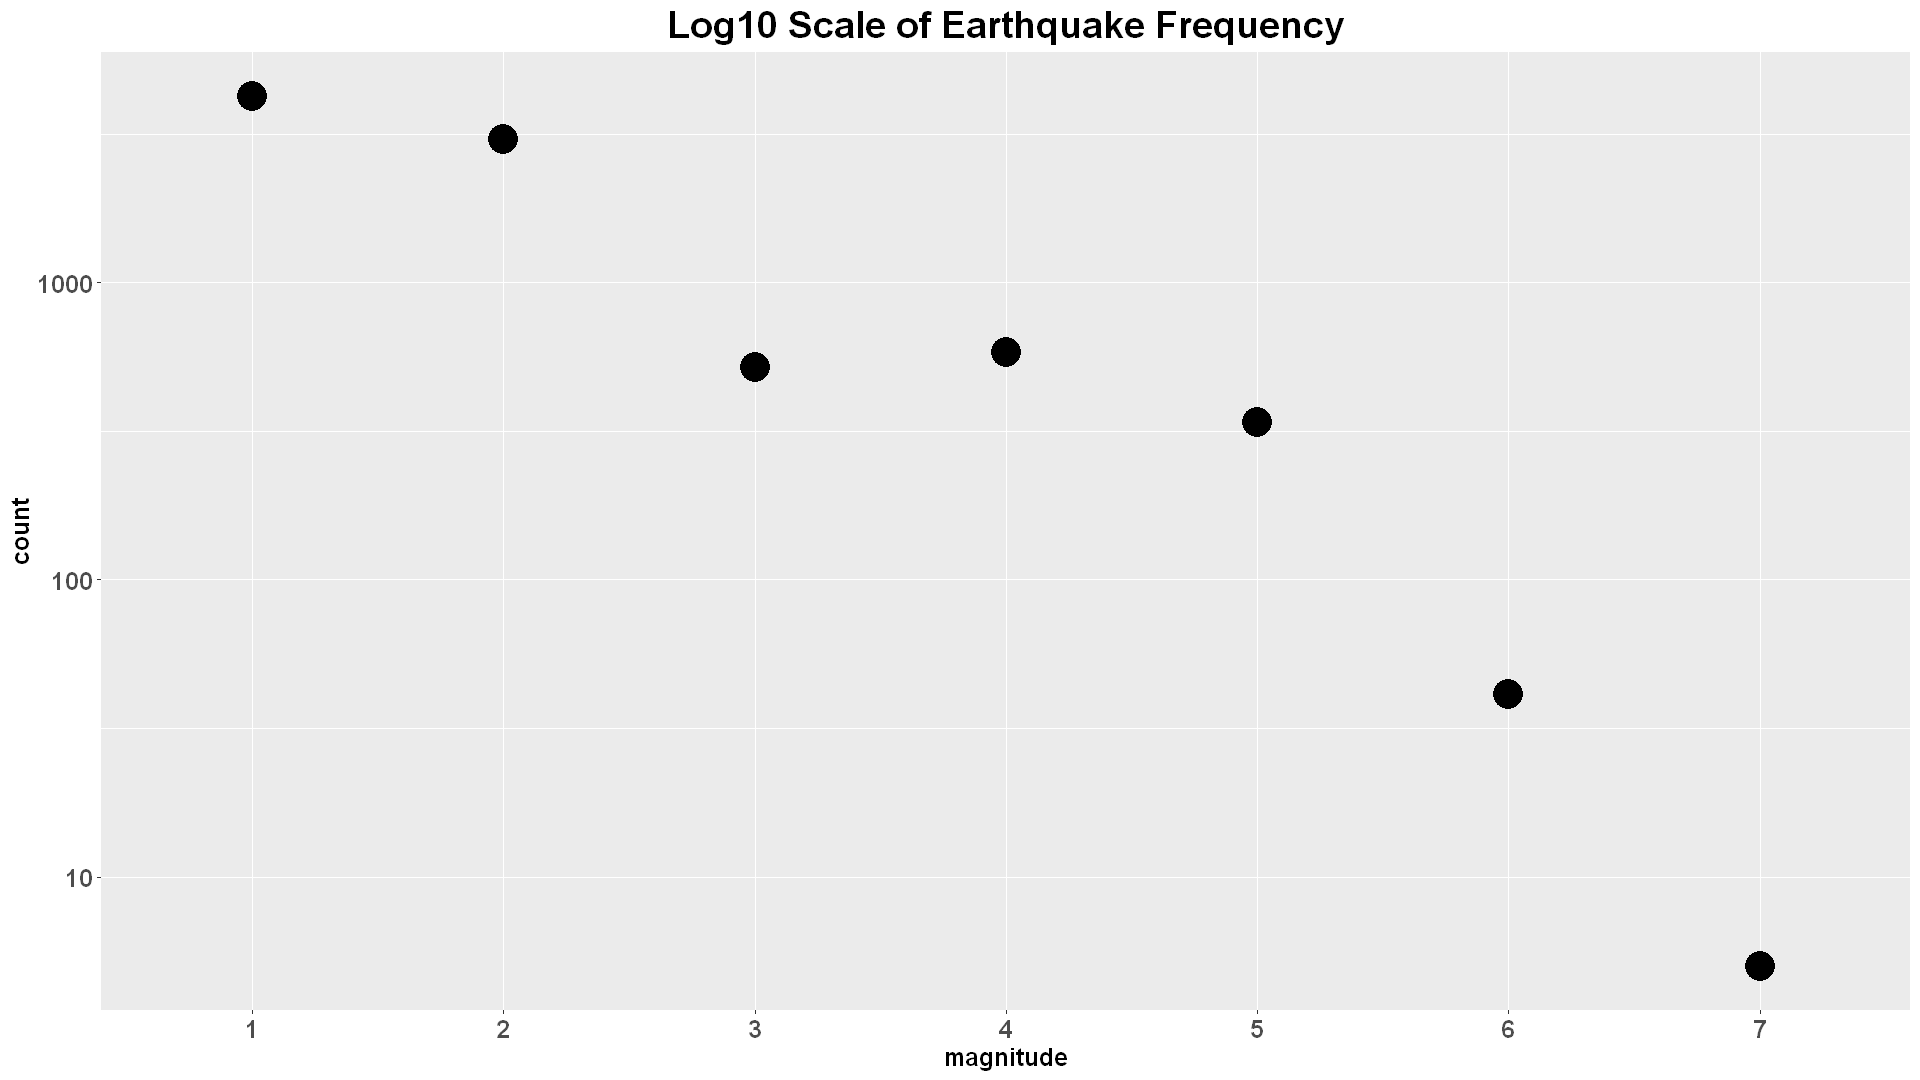

In [26]:
# 1. Keep only non-negative measures
earthquakes2 <- subset(earthquakes, mag>0.5)

# 2. Round magninutes to integers to create a scale
magnitude <- factor(round(earthquakes2$mag))

# 3. Plot earthquake frequency on log scale
pltt <- ggplot() + 
        geom_point(aes(magnitude), stat = "count", size=8) +
        scale_y_log10() +
        ggtitle("Log10 Scale of Earthquake Frequency") +
        theme(plot.title = element_text(size = 22, face = "bold")) +
        theme(axis.text.x = element_text(size=15, face = "bold")) + 
        theme(axis.text.y = element_text(size=15, face = "bold")) +
        theme(axis.title = element_text(size=15, face = "bold"))

# And the resulting plot is:
pltt

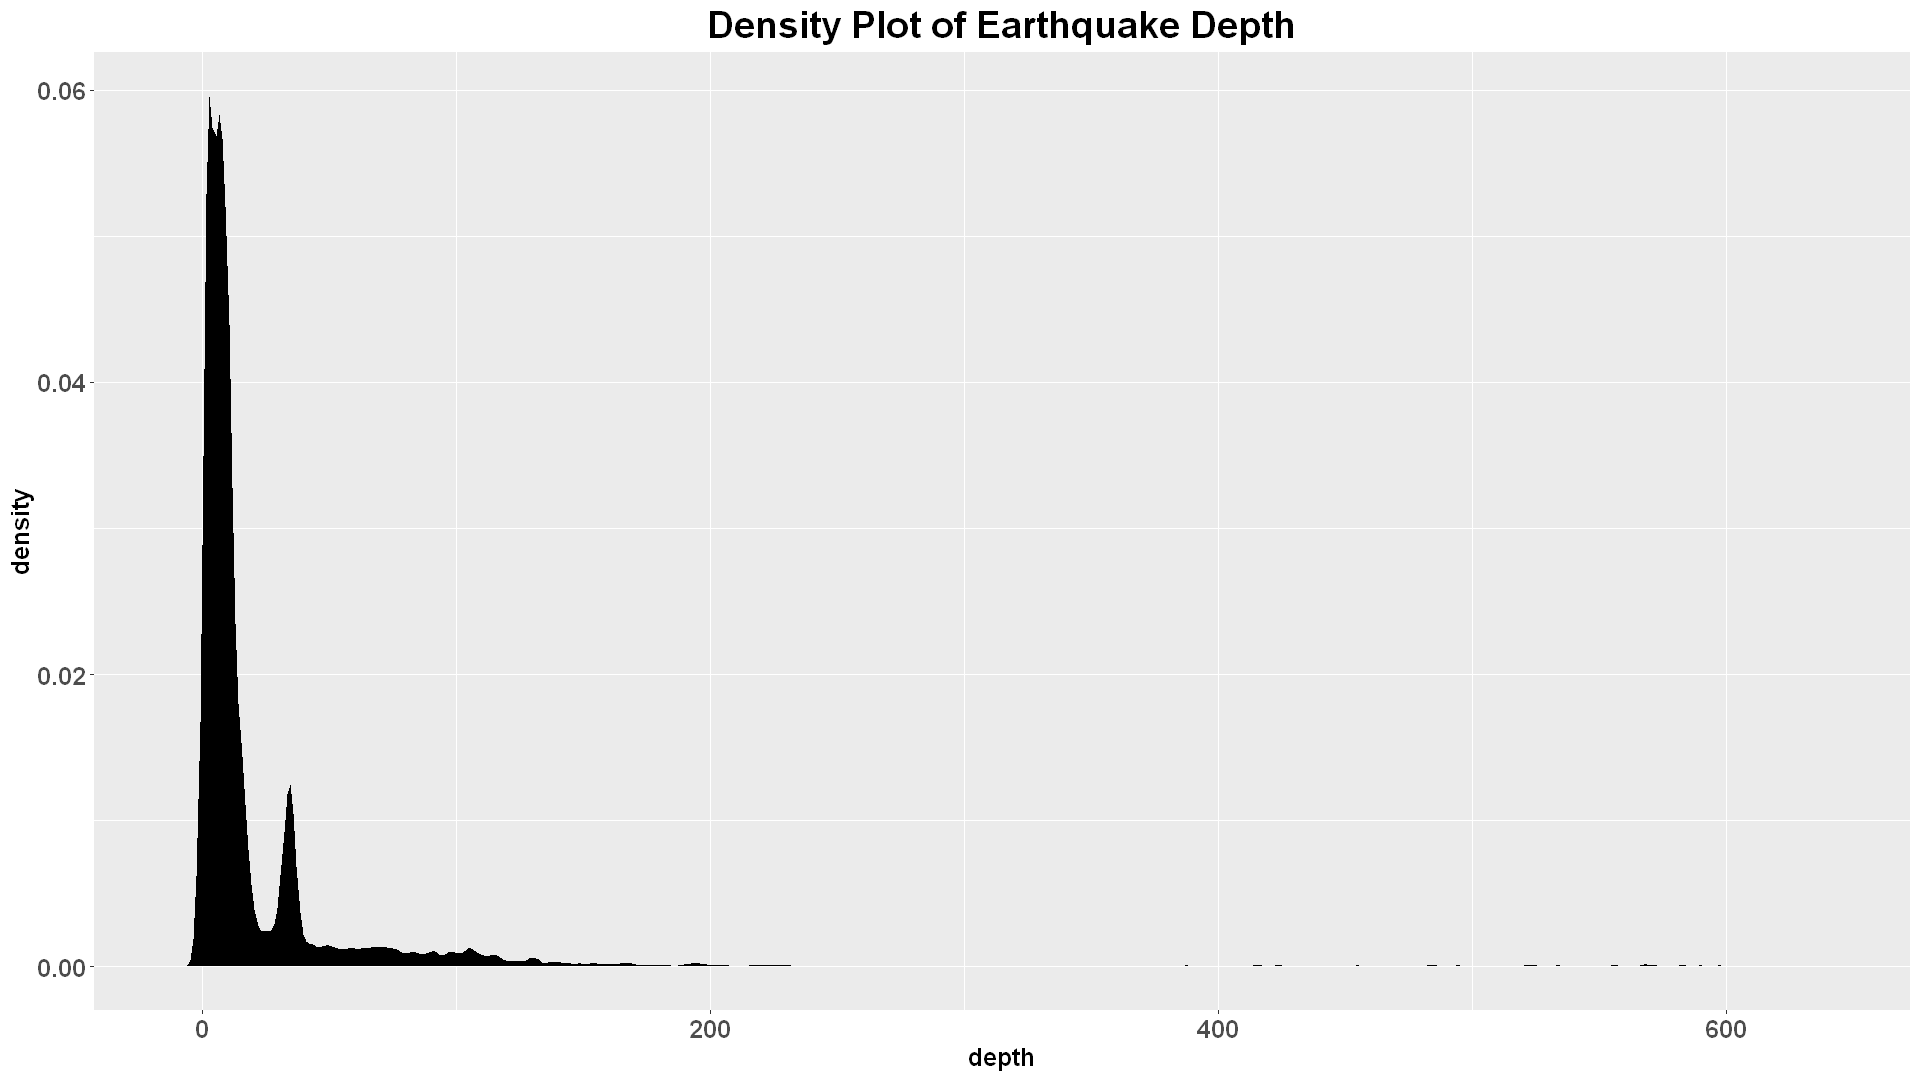

In [14]:
# Density Plot of Earthquake Depth
pltt <- ggplot(earthquakes, aes(x=depth)) + 
        geom_density(colour = FALSE, fill = "black") +
        ggtitle("Density Plot of Earthquake Depth") +
        theme(plot.title = element_text(size = 22, face = "bold")) +
        theme(axis.text.x = element_text(size=15, face = "bold")) + 
        theme(axis.text.y = element_text(size=15, face = "bold")) +
        theme(axis.title = element_text(size=15, face = "bold")) 

# And the resulting plot is:
pltt

## Static Maps

Starting off slow with simpler static maps.

### ggplot2

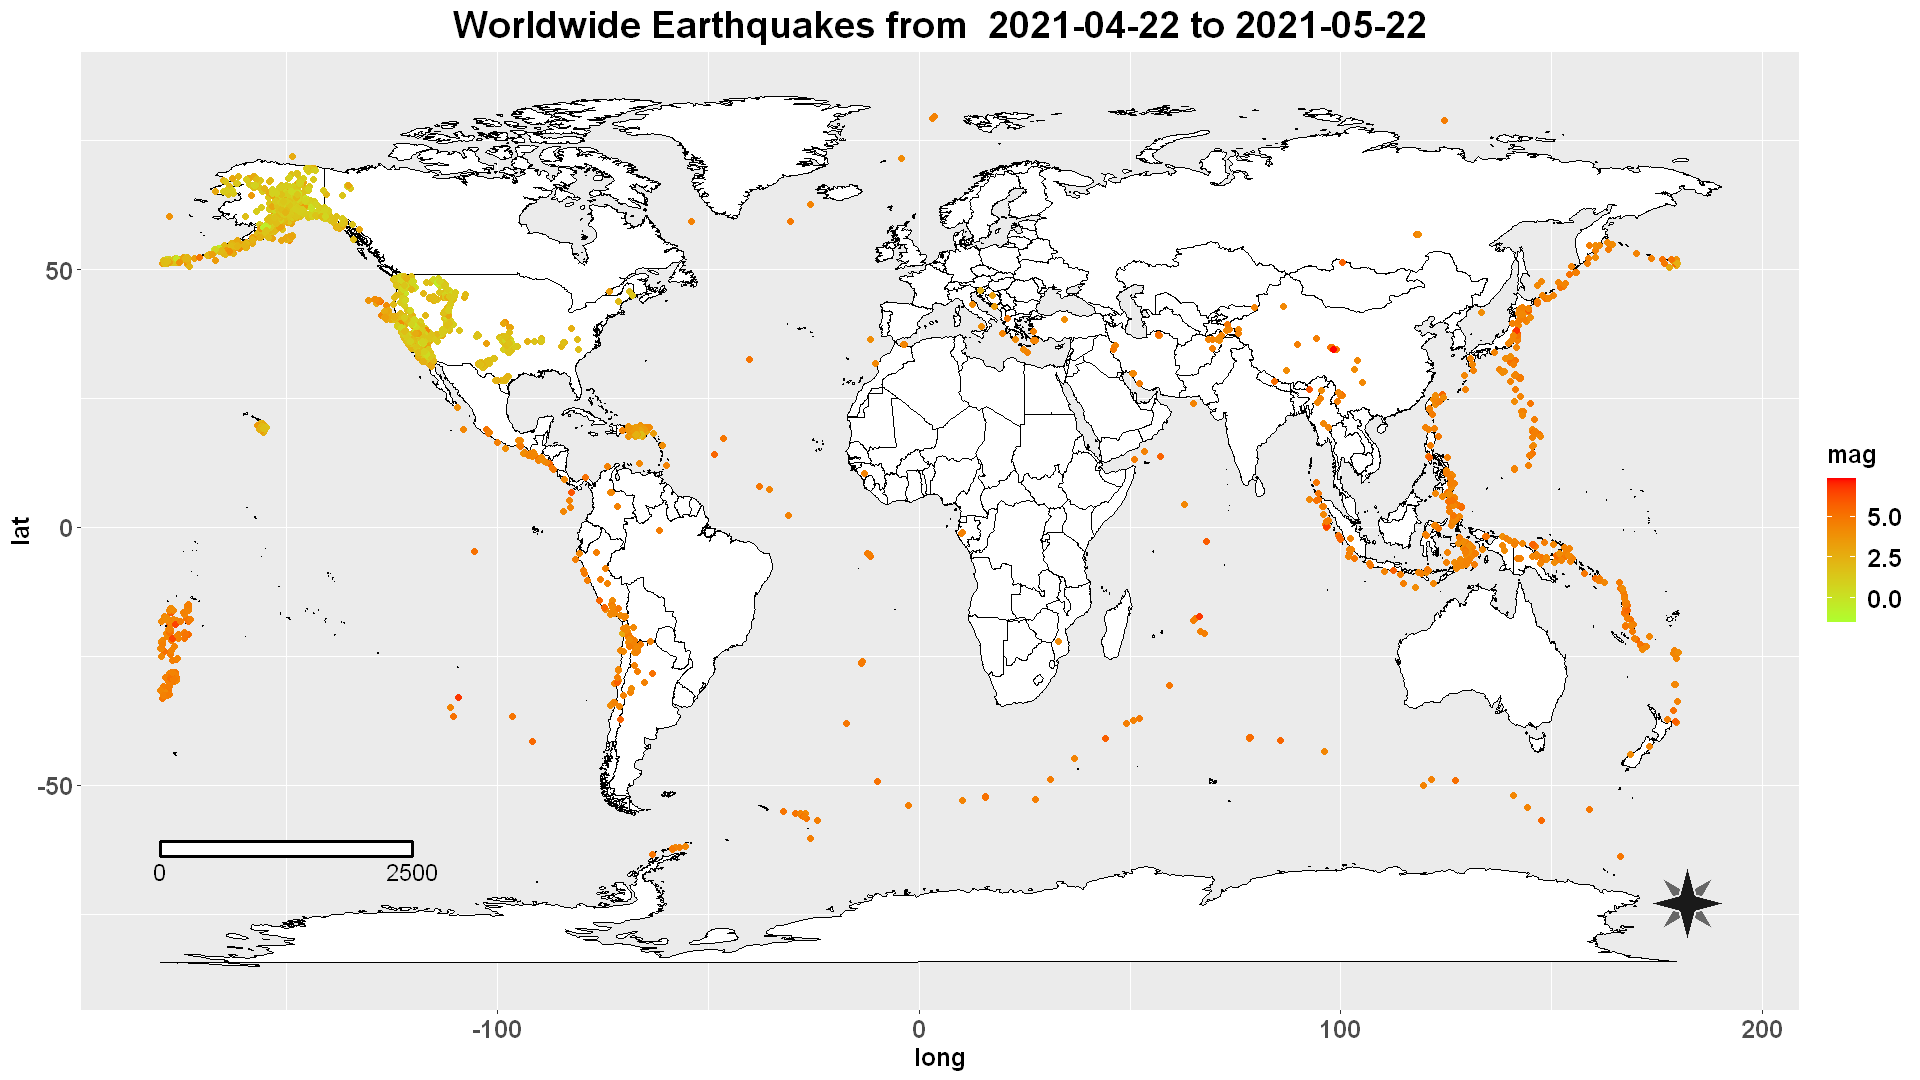

In [15]:
# 1. Get a world map for plotting
world_map <- map_data('world')

# 2. Crete a ggplot object based on the geom_map() geometry, in order to obtain the polygons from a reference map
pltt <- ggplot() +
        geom_map(data=world_map, map=world_map, 
                 aes(x=long, y=lat, map_id=region), 
                 fill='white', colour="black", size=0.5)

# 3. Add the datapoints in the earthquakes dataframe to the ggplot object from above
pltt <- pltt +
        geom_point(data=earthquakes, aes(x=longitude, y=latitude, colour=mag)) +
        scale_colour_gradient(low="greenyellow", high="red", limits=c(min(earthquakes$mag),max(earthquakes$mag)))

# 4. Define the plotting title, that indicates the dates the plot covers
title <- paste("Worldwide Earthquakes from ", 
               paste(as.Date(earthquakes$time[nrow(earthquakes)]), 
                     as.Date(earthquakes$time[1]), 
                           sep = " to "))
pltt <- pltt + 
        ggtitle(title) +
        theme(plot.title = element_text(size = 22, face = "bold")) +
        theme(axis.text.x = element_text(size=15, face = "bold")) + 
        theme(axis.text.y = element_text(size=15, face = "bold")) +
        theme(axis.title = element_text(size=15, face = "bold")) +
        theme(legend.title = element_text(size=15, face = "bold")) +
        theme(legend.text = element_text(size=15, face = "bold"))

# 5. Add a compass to the map
pltt <- pltt +
        ggsn::north(data=earthquakes, location='bottomright', anchor=c("x"=200, "y"=-80), symbol=15)

# 6. Add a scale bar to the plot
pltt <- pltt +
        ggsn::scalebar(data=earthquakes, location="bottomleft", dist=2500, dist_unit="km", transform=TRUE, model="WGS84")

# And the resulting plot is:
pltt

### tmap

#### World Map

tmap mode set to plotting

Compass not supported in view mode.

Interactive map saved to C:\Portfolio\Earthquake_Maps\map3.html

Scale bar set for latitude km and will be different at the top and bottom of the map.



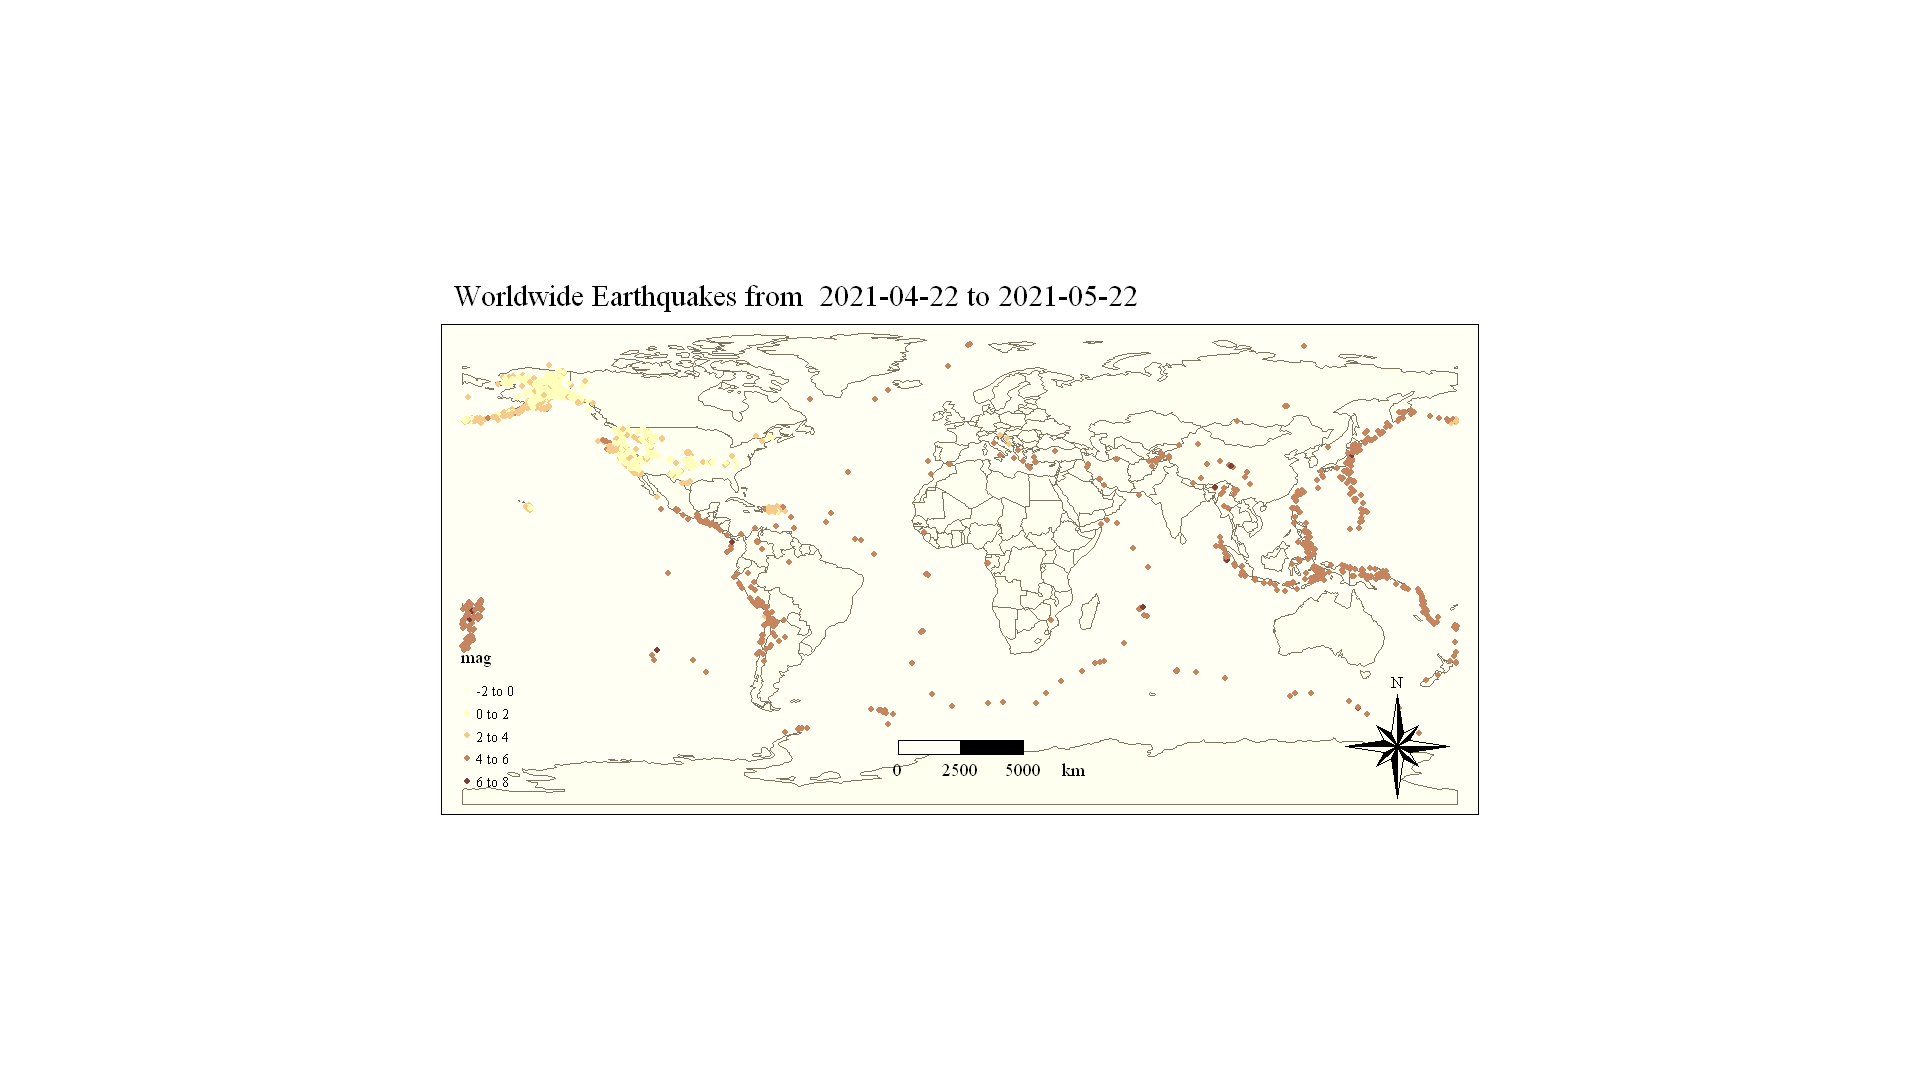

In [16]:
# 1. Set the parameters for the the WGS84 projection
projcrs <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

# 2. Convert the earthquake dataset to a Simple Features object with spData
sf_obj <- st_as_sf(x=earthquakes, coords=c("longitude", "latitude"), crs=projcrs)

# 3. Create a tmap world map
tmap_mode("plot")
pltt <- tm_shape(spData::world)

# 4. Define the map style
pltt <- pltt +
        tm_style("classic") +
        tm_fill(col="white") +
        tm_borders() +
        tm_layout(frame.lwd=0)

# 5. Add a title
title <- paste("Worldwide Earthquakes from ", 
               paste(as.Date(earthquakes$time[nrow(earthquakes)]), 
                     as.Date(earthquakes$time[1]), 
                           sep = " to "))
pltt <- pltt + 
        tm_layout(main.title=title)

# 6. Add a compass to the map
pltt <- pltt +
        tm_compass(type="8star", position=c("right", "bottom"))

# 7. Add a scale bar to the plot
pltt <- pltt +
        tm_scale_bar(breaks=c(0, 2500, 5000), size=1, position=c("left", "bottom"))

# 8. Add the data (as sf_obj) to the plotting object
pltt <- pltt +
        tm_shape(sf_obj)

# 9. Display the earthquakes as dots in the map
pltt <- pltt +
        tm_dots(size=0.1, col="mag", palette="YlOrRd")

# Saving the map as an interactive html.
tmap_save(pltt, filename="map3.html")

pltt

#### California Map

although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar

tmap mode set to plotting



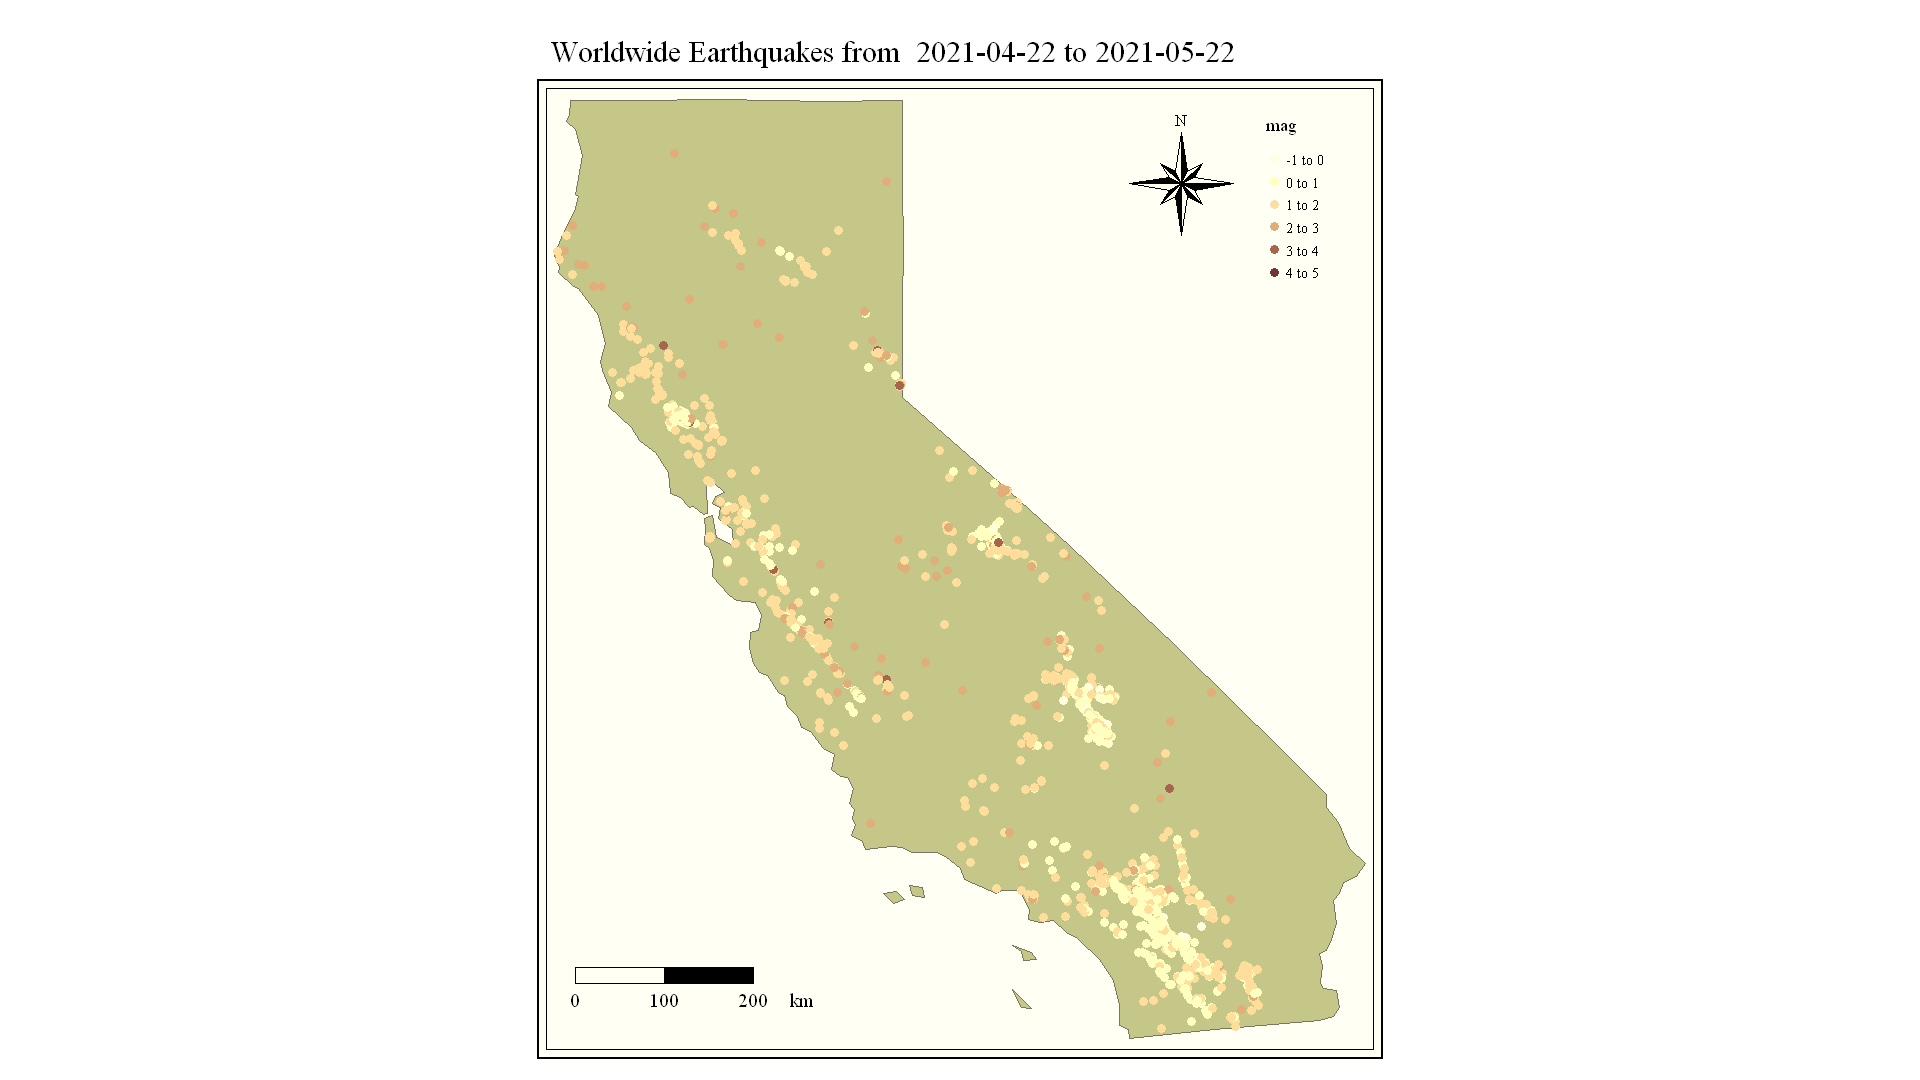

In [17]:
# 1. Get the California map by filtering the California state map from the United States map available on spData 
california_map <- spData::us_states %>% filter(NAME == "California") 

# 2. Convert the earthquake dataset to a Simple Features object with spData
sf_obj <- st_as_sf(x=earthquakes, coords=c("longitude", "latitude"), crs=st_crs(california_map))

# 3. Inner-Join the Simple Features object with the California map, to keep only the datapoints for earthquakes in California
california_earthquakes <- st_join(sf_obj, california_map, left=FALSE)

# 4. Create a tmap object of the california map
tmap_mode("plot")
pltt <- tm_shape(california_map)

# 5. Define map style
pltt <- pltt +
        tm_style("classic") +
        tm_fill(col="green") + 
        tm_borders()

# 6. Add a title
title <- paste("Worldwide Earthquakes from ", 
               paste(as.Date(earthquakes$time[nrow(earthquakes)]), 
                     as.Date(earthquakes$time[1]), 
                           sep = " to "))
pltt <- pltt + 
        tm_layout(main.title=title) 

# 7. Add a compass to the map
pltt <- pltt +
        tm_compass(type="8star", position=c("right", "top"))

# 8. Add a scale bar to the plot
pltt <- pltt +
        tm_scale_bar(breaks=c(0, 100, 200), size=1, position=c("left", "bottom"))

# 9. Add the data (as sf_obj) to the plotting object
pltt <- pltt +
        tm_shape(california_earthquakes)

# 10. Display the earthquakes as dots in the map
pltt <- pltt +
        tm_dots(size=0.25, col="mag", palette="YlOrRd")

# And the resulting plot is:
pltt    

### ggmap

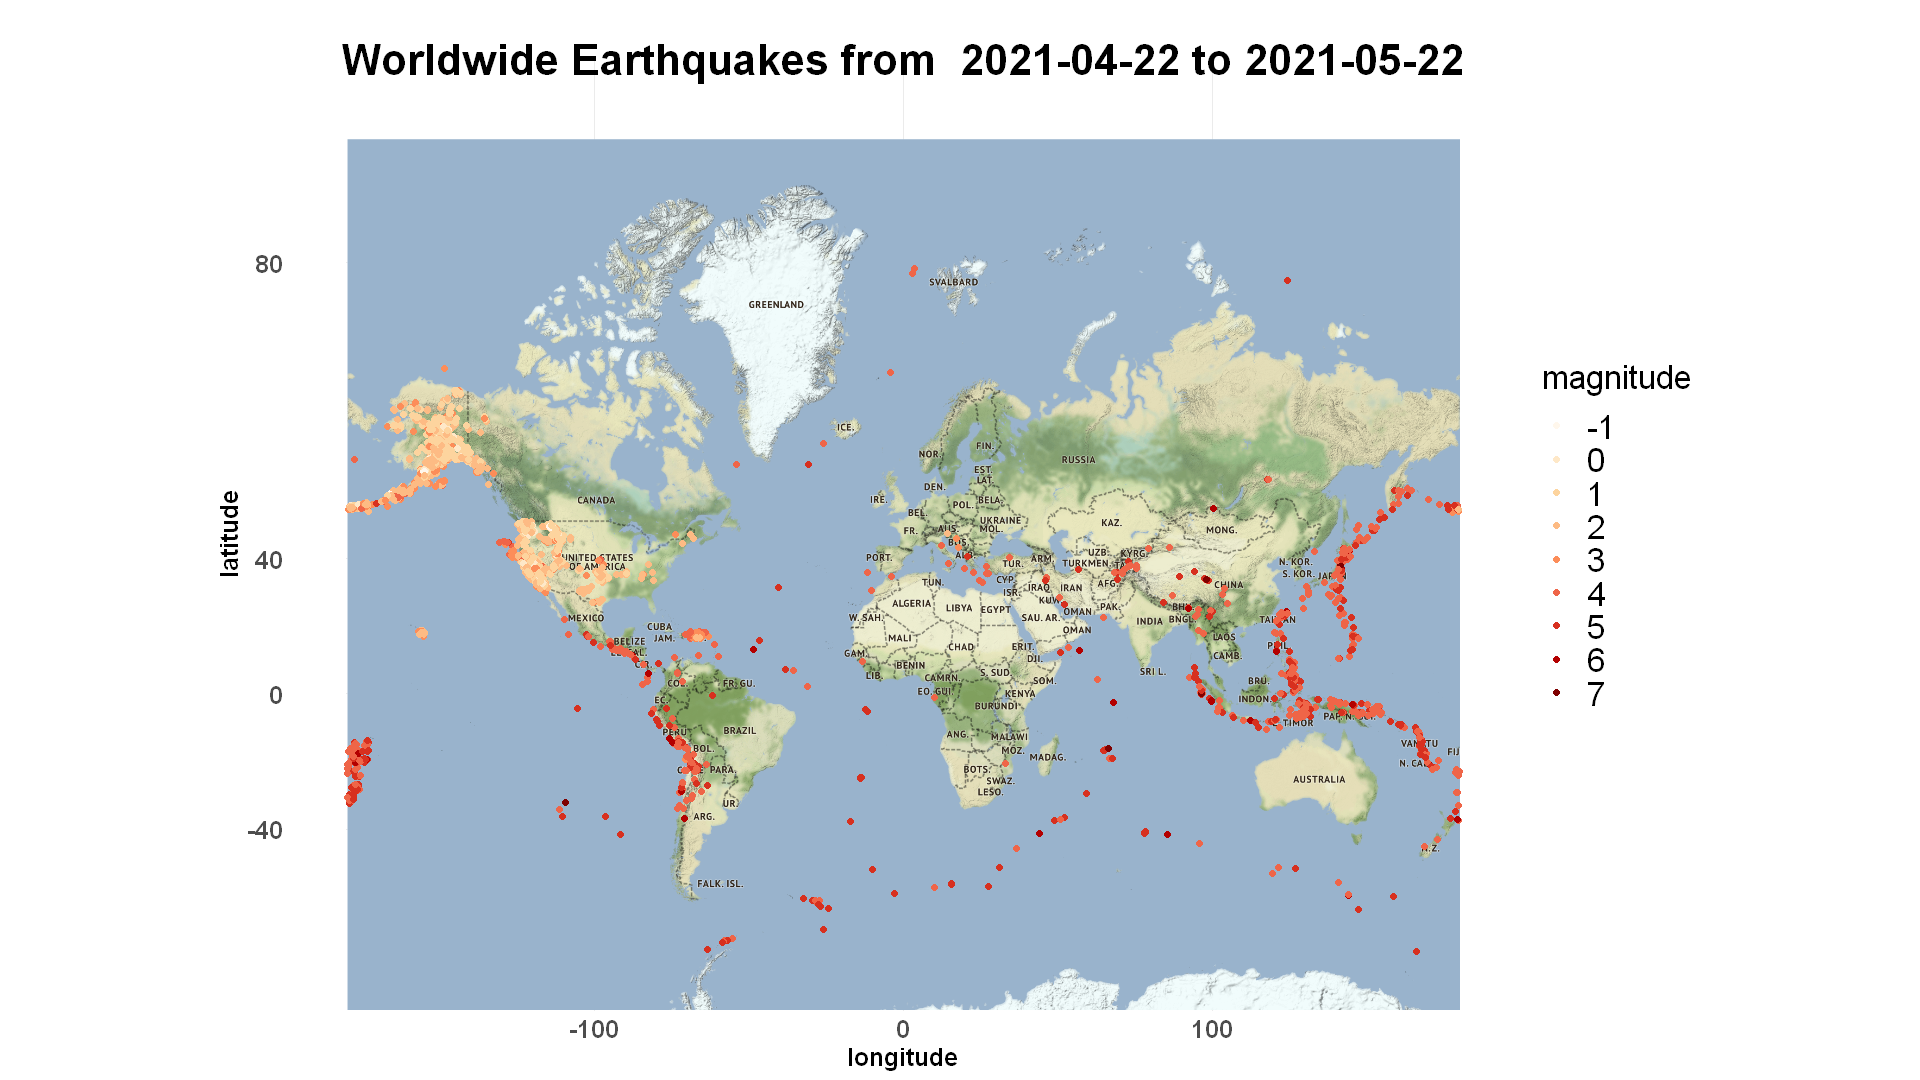

In [18]:
# 1. Define a title
title <- paste("Worldwide Earthquakes from ", 
               paste(as.Date(earthquakes$time[nrow(earthquakes)]), 
                     as.Date(earthquakes$time[1]), 
                           sep = " to "))

# 2. Round magninutes to integers to create a scale
magnitude <- factor(round(earthquakes$mag))

# 3. Plot with ggmap's qmplot
pltt <- suppressMessages(
        qmplot(data=earthquakes, x=longitude, y=latitude, geom="point", colour=magnitude, source="stamen", zoom=3) +
        scale_color_brewer(palette=8) +
        ggtitle(title)) +
        theme_minimal() +
        theme(plot.title=element_text(family='', face='bold', colour='Black', size=26, hjust = 0.5, vjust=-3),
              legend.text = element_text(size=20),
              legend.title = element_text(size=20)) +
        theme(axis.text.x = element_text(size=15, face = "bold")) + 
        theme(axis.text.y = element_text(size=15, face = "bold")) +
        theme(axis.title = element_text(size=15, face = "bold"))

# And the resulting plot is:
pltt    

## Interactive Maps

Now we're talking!

## leaflet

In [19]:
# Use tidyverse's piping to concanate all we need to make the map
pltt <- earthquakes %>%
        leaflet() %>%
        addTiles() %>%
        addMarkers(~longitude, ~latitude,
                   popup = (paste("Place: ", earthquakes$place, "<br>", 
                                  "Id: ", earthquakes$id, "<br>",
                                  "Time: ", earthquakes$time, "<br>",
                                  "Magnitude: ", earthquakes$mag, " m <br>",
                                  "Depth: ", earthquakes$depth)),
                   clusterOptions = markerClusterOptions())

# Saving the map as an interactive html.
saveWidget(pltt, file="map1.html")

> View the interactive map here: [Leaflet Interactive Map](./map1.html)

### tmap

In [20]:
# 1. Set the parameters for the the WGS84 projection
projcrs <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

# 2. Convert the earthquake dataset to a Simple Features object with spData
sf_obj <- st_as_sf(x=earthquakes, coords=c("longitude", "latitude"), crs=projcrs)

# 3. Set tmap's mode to view, which allows for animations (default is "plot" which is static)
tmap_mode("view")

# 4. Create a tmap world map
pltt <- tm_shape(spData::world)

# 5. Define the map style
pltt <- pltt +
        tm_style("natural") +
        tm_borders()

# 6. Add a title
title <- paste("Worldwide Earthquakes from ", 
               paste(as.Date(earthquakes$time[nrow(earthquakes)]), 
                     as.Date(earthquakes$time[1]), 
                           sep = " to "))
pltt <- pltt + 
        tm_layout(main.title=title)

# 7. Add the data (as sf_obj) to the plotting object
pltt <- pltt +
        tm_shape(sf_obj)

# 8. Display the earthquakes as dots in the map
pltt <- pltt +
        tm_dots(size=0.1, col="mag", palette="YlOrRd")

# Saving the map as an interactive html.
tmap_save(pltt, filename="map2.html")

tmap mode set to interactive viewing

Interactive map saved to C:\Portfolio\Earthquake_Maps\map2.html



> View the interactive map here: [Tmap Interactive Map](./map2.html)

### mapview

In [ ]:
# 1. Set the parameters for the the WGS84 projection
projcrs <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

# 2. Convert the earthquake dataset to a Simple Features object with spData
sf_obj <- st_as_sf(x=earthquakes, coords=c("longitude", "latitude"), crs=projcrs)

# 3. Define a color palette for the intensity scale
custom_palette <- colorRampPalette(c("green", "yellow", "orange", "red"))

# 4. Plot with mapview
pltt <- mapview(sf_obj, 
                popup = popupTable(sf_obj, zcol=c("place", "mag")),
                zcol = "mag", 
                legend = TRUE,
                map.types = c("CartDB.Positron"),
                cex = 4,
                alpha = 0.3,
                col.regions = custom_palette(8))

# Save to html for interactive visualization
mapshot(pltt, file="map3.html")

> View the interactive map here: [Mapview Interactive Map](./map3.html)

### plotly

In [22]:
# 1. Get a world map for plotting
world_map <- map_data('world')

# 2. Assign each sample to a country based on its (longitude, latitude)
earthquakes$country <- map.where(database="world", earthquakes$longitude, earthquakes$latitude)

# 3. Count earthquakes per country and average magnitude
country_earthquakes <- earthquakes %>% 
                        group_by(country) %>% 
                        dplyr::summarise(n = n(), 
                                         mean_mag = mean(mag, na.rm=T),
                                         score = n() * mean(mag, na.rm=T))

# 4. Get country codes for indexing in the map
country_earthquakes$code <- countrycode(country_earthquakes$country, origin = 'country.name', destination = 'iso3c') 

# 5. Choroplet map of num_earthquakes * mean_mag for each country
pltt <- plot_ly(country_earthquakes, 
                type='choropleth', 
                locations=country_earthquakes$code, 
                z=log(country_earthquakes$score, base = 10), 
                colorscale="Reds")

# 6. Plotly geo-styling parameters
g <- list(
    scope = 'world',
    showcountries = TRUE,
    countrycolor = 'lightgray',
    showland = TRUE,
    landcolor = 'whitesmoke',
    showlakes = TRUE,  
    lakecolor = 'white',
    showocean = TRUE,
    oceancolor = 'lightblue')

pltt <- pltt %>% layout(geo = g)

# 7. Title
pltt <- pltt %>% layout(title = list(text = '<b>Choropleth Map of Earthquake Intensity per Country</b>', y = 0.985))

# 8. Colorbar
pltt <- pltt %>% colorbar(title = "    Log10 of\nFrequency\n      x\nMagnitude")

# Save to html for interactive visualization
saveWidget(pltt, file="map4.html")

> View the interactive map here: [Plotly Interactive Map](./map4.html)

## Animated Maps

Can we do even better than interactive maps? Yes!  

Animated maps with timelapses can be pretty cool.

### animation

In [23]:
# 1. Determine the number of days to be displayed, with one frame per day
days <- unique(as.Date(earthquakes$time))
frames <- length(days)

# 2. Set the bbox size for the resulting GIF
bbox <- make_bbox(lon=c(-180,180), lat=c(-70,70), f=0)

# 3. Initialize a world map from ggmap
map <- get_map(location = bbox,
               zoom = 3,
               source = "stamen", 
               maptype = "terrain",
               force = FALSE)

# 4. Generate and save the gif
saveGIF( {
    for (day in frames:1) {
        # 4.1 Get the current day
        today <- days[day]
        # 4.2 Get earthquakes from the current day
        earthquakes_today <- earthquakes %>% filter(as.Date(time) == today)
        # 4.3 The the earthquakes' magnitudes
        magnitude <- factor(round(earthquakes_today$mag))
        # 4.4 Plot today's earthquakes
        pltt <- ggmap(map) +
                # Add data datapoints as points in the map
                geom_point(data = earthquakes_today, aes(x=longitude, y=latitude, color=mag, size=.5)) +
                # Add a scale bar
                scale_colour_gradient(low="greenyellow", high="red", limits=c(min(earthquakes$mag),max(earthquakes$mag))) +
                # aa
                ggtitle(today) +
                theme(plot.title = element_text(size = 22, face = "bold")) +
                theme(axis.text.x = element_text(size=15, face = "bold")) + 
                theme(axis.text.y = element_text(size=15, face = "bold")) +
                theme(axis.title = element_text(size=15, face = "bold"))
        # 4.5 Plot
        plot(pltt)
    }
  },
        interval = 1, nmax = 1, ani.width = 1000, ani.height = 1000, movie.name = "earthquakes1.gif")

54 tiles needed, this may take a while (try a smaller zoom).

Output at: earthquakes1.gif



[1] TRUE

> View the GIF here: [animation GIF](./earthquakes1.gif)

### gganimate

In [24]:
# 1. Add a day column to each datapoint
earthquakes$date <- as.Date(earthquakes$time)

# 2. Determine the number of days to be displayed, with one frame per day
days <- unique(earthquakes$date)
frames <- length(days)

# 3. Define a color palette for the intensity scale
custom_palette <- colorRampPalette(c("green", "yellow", "orange", "red"))

# 4. Instantiate a world map figure 
world_map <- ggplot() +
             borders("world", colour="gray65", fill="gray50") +
             theme_map() +
             geom_point(data=earthquakes, aes(x=longitude, y=latitude, colour=mag, frame=date, cumulative=TRUE), size=3) +
             scale_colour_gradient(low="greenyellow", high="red", limits=c(min(earthquakes$mag),max(earthquakes$mag))) +
             geom_text(data = earthquakes, aes(-100, 100, label=date)) +
             transition_time(date) +
             enter_fade() + 
             exit_fade() +
             theme(plot.title = element_text(size = 22, face = "bold")) +
             theme(axis.text.x = element_text(size=15, face = "bold")) + 
             theme(axis.text.y = element_text(size=15, face = "bold")) +
             theme(axis.title = element_text(size=15, face = "bold"))


# 5. Set animation parameters
options(gganimate.dev_args = list(width = 1000, height = 600))

# 6. Generate GIF
suppressMessages(animate(world_map, nframes = frames, duration = frames, renderer = gifski_renderer("earthquakes2.gif")))

> View the GIF here: [gganimate GIF](./earthquakes2.gif)

## tmap

In [25]:
# 1. Add a day column to each datapoint
earthquakes$date <- as.Date(earthquakes$time)

# 2. Convert the earthquake dataset to a Simple Features object with spData
sf_obj <- st_as_sf(x=earthquakes, coords=c("longitude", "latitude"), crs=st_crs(spData::world))

# 3. Create a tmap object with the world map
tmap_mode("plot")
pltt <- tm_shape(spData::world) 

# 4. Add styling to the map
pltt <- pltt + 
        tm_style("natural") + 
        tm_fill(col = "gray") + 
        tm_borders() 

# 5. Add a compass
pltt <- pltt + 
        tm_compass(type = "8star", position = c("right", "top")) 

# 6. Add a scale bar
pltt <- pltt + 
        tm_scale_bar(breaks = c(0, 2500, 5000), size = 1, position = c("left", "bottom")) 

# 7. Add dataset in Simple Features format
pltt <- pltt + tm_shape(sf_obj) 

# 8. Add datapoints as dots
pltt <- pltt + 
        tm_dots(size=0.33, col="mag", palette = "YlOrRd") 

# 9. Split into facets (images), one per day in the dataset
pltt <- pltt + 
        tm_facets(along = "date", free.coords = TRUE)

# 10. Save a GIF concatenating all facets in sequence
tmap_animation(pltt, filename = "earthquakes3.gif", delay = 100)

tmap mode set to plotting



Creating frames
Creating animation
Frame 31 (100%)
Finalizing encoding... done!
Animation saved to C:\Portfolio\Earthquake_Maps\earthquakes3.gif 


> View the GIF here: [tmap GIF](./earthquakes3.gif)

# End
Matheus Schmitz  
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a>  
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>  